Projeto: Segmentação de Clientes de Cartão de Crédito (Clustering)

Objetivo: Traduzir os clusters identificados em insights acionáveis para as equipes de Marketing e Produto.

Dataset: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data

### 1. Importação de Bibliotecas

In [21]:
#Importação das bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample # Módulo para amostragem
#from scipy.stats import f_oneway, skew, kurtosis, boxcox, yeojohnson

### Formatação de Tabelas e Estilo Visual

In [2]:
# Configurações
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set(style="whitegrid")
pd.options.display.float_format = '{:.2f}'.format

### Funções auxiliares

In [ ]:
# Funções auxiliares

# calcular Estatística F para cada variável
def f_test_clusters(df, cluster_col='cluster'):
    numericas = df.select_dtypes(include=['float64', 'int64']).columns
    numericas = [col for col in numericas if col != cluster_col]

    resultados = []

    for col in numericas:
        grupos = [df[df[cluster_col] == c][col] for c in df[cluster_col].unique()]

        f_stat, p_val = f_oneway(*grupos)
        resultados.append([col, f_stat, p_val])

    resultado_df = pd.DataFrame(resultados, columns=['Variável', 'F-stat', 'p-value'])
    resultado_df['Importância'] = resultado_df['F-stat'] / resultado_df['F-stat'].sum()
    return resultado_df.sort_values(by='F-stat', ascending=False)

#Identificação de Valores Nulos
def calcular_porcentagem_nulos(df):
    nulos = df.isnull().sum()
    perc = (nulos / len(df)) * 100

    resultado = pd.DataFrame({
        'qtd_nulos': nulos,
        'perc_nulos': perc.apply(lambda x: f"{x:.3f}%")
    })

    return resultado[resultado['qtd_nulos'] > 0]\
        .sort_values(by='perc_nulos', ascending=False)

#Identificar Limites Inf e Sup
def calcular_limites_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return lim_inf, lim_sup

#Identificarção de Outliers
def detectar_outliers_iqr(df_local, coluna):
    lim_inf, lim_sup = calcular_limites_iqr(df_local[coluna])
    mask = (df_local[coluna] < lim_inf) | (df_local[coluna] > lim_sup)
    qtd = int(mask.sum())
    perc = qtd / len(df_local) * 100
    return {'coluna': coluna, 'lim_inf': lim_inf, 'lim_sup': lim_sup,
            'qtd_outliers': qtd, 'perc_outliers': perc}

#Marcação do Outliers na base
def criar_flag_outliers(df_local, coluna):
    lim_inf, lim_sup = calcular_limites_iqr(df_local[coluna])
    df_local[f'flag_outlier_{coluna}'] = np.where(
        (df_local[coluna] < lim_inf) | (df_local[coluna] > lim_sup), 1, 0
    )
    return df_local

#Grafico boxplot
def plotar_boxplots_numericos(df):
    colunas_numericas = df.select_dtypes(include=['number']).columns
    
    if colunas_numericas.empty:
        print("Nenhuma coluna numérica encontrada no DataFrame.")
        return

    print(f"Gerando {len(colunas_numericas)} boxplots para as colunas numéricas...")
    
    # Define o número de gráficos por linha e o número de linhas
    num_colunas = 3
    num_linhas = (len(colunas_numericas) + num_colunas - 1) // num_colunas
    
    # Cria a figura principal com múltiplos subplots
    # Ajusta o tamanho da figura para que os gráficos não fiquem apertados
    plt.figure(figsize=(6 * num_colunas, 5 * num_linhas))
    
    # Itera sobre as colunas numéricas e cria um gráfico em cada subplot
    for i, coluna in enumerate(colunas_numericas):
        
        # Cria um subplot para o gráfico atual
        plt.subplot(num_linhas, num_colunas, i + 1)
        
        # 1. Boxplot (na vertical)
        sns.boxplot(y=df[coluna], color='skyblue', linewidth=1.5, fliersize=0)
        
        # 2. Swarmplot para visualização de todos os pontos (incluindo outliers)
        # O 'x=0' é um truque para posicionar o swarmplot no centro do boxplot.
        sns.swarmplot(y=df[coluna], x=[0] * len(df[coluna]), color='black', size=3, ax=plt.gca())
        
        # Define o título do gráfico
        plt.title(f'Distribuição - {coluna}', fontsize=12)
        plt.xlabel('') # Remove o rótulo X, pois não há categoria
        plt.ylabel(coluna, fontsize=10)
        
        # Garante que o boxplot não tenha a linha lateral do eixo X
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
    # Ajusta o espaçamento entre os subplots para evitar sobreposição
    plt.tight_layout()
    plt.show()


In [4]:
#Função para explorar visualmente as distribuições

def explorar_distribuicoes(df, colunas=None, bins=40):
    """
    Gera gráficos de distribuição e boxplots para as variáveis numéricas.
    
    Parâmetros:
    - df: DataFrame com os dados
    - colunas: lista de colunas a visualizar (se None, pega todas as numéricas)
    - bins: número de bins no histograma
    """

    # Seleciona colunas numéricas se não for especificado
    if colunas is None:
        colunas = df.select_dtypes(include=['float64', 'int64']).columns

    num_cols = len(colunas)
    print(f"Gerando gráficos para {num_cols} variáveis numéricas...\n")

    # Define tamanho da figura dinamicamente
    ncols = 3
    nrows = int(np.ceil(num_cols / ncols))
    plt.figure(figsize=(6 * ncols, 5 * nrows))

    for i, col in enumerate(colunas, 1):
        plt.subplot(nrows, ncols, i)
        sns.histplot(df[col], kde=True, bins=bins, color='steelblue')
        plt.title(f'{col}\nSkew={df[col].skew():.2f}, Kurtosis={df[col].kurt():.2f}')
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

    # Boxplots agrupados abaixo
    plt.figure(figsize=(6 * ncols, 5 * nrows))
    for i, col in enumerate(colunas, 1):
        plt.subplot(nrows, ncols, i)
        sns.boxplot(y=df[col], color='lightcoral')
        plt.title(f'Boxplot - {col}')
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

In [5]:
# Diagnóstico de Distribuição e Assimetria

def diagnostico_distribuicao(df, colunas=None, threshold_assimetria=0.75):
    """
    Analisa a distribuição das variáveis numéricas e sugere transformações ideais.
    
    Parâmetros:
    - df: DataFrame
    - colunas: lista de colunas numéricas (se None, usa todas as numéricas)
    - threshold_assimetria: limite de assimetria para sugerir transformação
    
    Retorna:
    - DataFrame com skewness, curtose e sugestão de transformação.
    """
    if colunas is None:
        colunas = df.select_dtypes(include=['number']).columns

    resultados = []

    for col in colunas:
        serie = df[col].dropna()
        skew_val = skew(serie)
        kurt_val = kurtosis(serie)
        
        # Sugestão de transformação
        if skew_val > threshold_assimetria:
            sugestao = "Log (assimetria positiva)"
        elif skew_val < -threshold_assimetria:
            sugestao = "Box-Cox ou Yeo-Johnson (assimetria negativa)"
        else:
            sugestao = "Nenhuma (distribuição aproximadamente simétrica)"
        
        resultados.append({
            'Variável': col,
            'Assimetria (Skewness)': round(skew_val, 3),
            'Curtose': round(kurt_val, 3),
            'Sugestão de Transformação': sugestao
        })

    return pd.DataFrame(resultados).sort_values(by='Assimetria (Skewness)', ascending=False)

In [6]:
# Aplicação Manual de Transformações

def aplicar_transformacao(df, colunas, metodo='log'):
    """
    Aplica transformação escolhida (log, boxcox ou yeojohnson) nas colunas indicadas.

    Parâmetros:
    - df: DataFrame
    - colunas: lista de colunas a transformar
    - metodo: 'log', 'boxcox' ou 'yeojohnson'

    Retorna:
    - Novo DataFrame com colunas transformadas
    """
    df_transformado = df.copy()

    for col in colunas:
        if metodo == 'log':
            df_transformado[col] = np.log1p(df_transformado[col].clip(lower=0))
        elif metodo == 'boxcox':
            # Box-Cox requer todos os valores > 0
            positivos = df_transformado[col] > 0
            df_transformado.loc[positivos, col], _ = boxcox(df_transformado.loc[positivos, col])
        elif metodo == 'yeojohnson':
            df_transformado[col], _ = yeojohnson(df_transformado[col])
        else:
            raise ValueError("Método inválido. Use: 'log', 'boxcox' ou 'yeojohnson'.")

    return df_transformado

In [7]:
# Função para comparar distribuições antes e depois da transformação

def comparar_distribuicoes(df, colunas, metodo='log'):
    """
    Compara distribuições antes e depois da transformação.
    
    Parâmetros:
    - df: DataFrame original
    - colunas: lista de colunas a serem transformadas
    - metodo: 'log', 'boxcox' ou 'yeojohnson'
    """
    
    # Copia o DataFrame original
    df_copia = df.copy()
    
    # Cria um dicionário para armazenar resultados de skewness antes e depois
    resultados = []

    for col in colunas:
        dados_originais = df_copia[col].dropna()

        # Aplicar transformação conforme o método escolhido
        if metodo == 'log':
            dados_transformados = np.log1p(dados_originais)  # log(1+x)
        elif metodo == 'boxcox':
            # Box-Cox só funciona com valores > 0
            dados_transformados = stats.boxcox(dados_originais + 1e-6)[0]
        elif metodo == 'yeojohnson':
            pt = PowerTransformer(method='yeo-johnson')
            dados_transformados = pt.fit_transform(dados_originais.values.reshape(-1, 1)).flatten()
        else:
            raise ValueError("Método inválido. Escolha: 'log', 'boxcox' ou 'yeojohnson'.")

        # Armazena skewness antes e depois
        skew_antes = stats.skew(dados_originais)
        skew_depois = stats.skew(dados_transformados)

        resultados.append({
            'Variável': col,
            'Skew antes': skew_antes,
            'Skew depois': skew_depois,
            'Melhorou': abs(skew_depois) < abs(skew_antes)
        })

        # Gráfico de comparação
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        sns.histplot(dados_originais, kde=True, color='skyblue', ax=axes[0])
        sns.histplot(dados_transformados, kde=True, color='salmon', ax=axes[1])

        axes[0].set_title(f'{col} - Antes (Skew={skew_antes:.2f})')
        axes[1].set_title(f'{col} - Depois ({metodo}) (Skew={skew_depois:.2f})')
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(resultados)

In [36]:
# Criando um mapa de calor da médias dos cluster por variaveis

def plot_heatmap_clusters(df_clusters_means, figsize=(12, 6), cmap='YlGnBu'):
    """
    Cria um mapa de calor (heatmap) para comparar as médias das variáveis entre clusters.
    
    Parâmetros:
    - df_clusters_means: DataFrame com o índice sendo o número do cluster e colunas as variáveis.
    - figsize: tamanho da figura (largura, altura)
    - cmap: paleta de cores (ex: 'YlGnBu', 'coolwarm', 'viridis')
    """
    plt.figure(figsize=figsize)
    
    # Normaliza os valores (0 a 1) para facilitar comparação visual
    df_norm = (df_clusters_means - df_clusters_means.min()) / (df_clusters_means.max() - df_clusters_means.min())
    
    sns.heatmap(df_norm, annot=True, fmt=".2f", cmap=cmap, cbar=True)
    plt.title('Mapa de Calor - Médias por Cluster', fontsize=14, fontweight='bold')
    plt.xlabel('Variáveis', fontsize=12)
    plt.ylabel('Clusters', fontsize=12)
    plt.show()

### 2. Carregar Base de Dados

In [8]:
#Importando os dados

## Fonte: Kaggle

df = pd.read_csv('CC GENERAL.csv')
df_cluster = df.copy()

### Visualizando os dados e cada uma das variáveis

In [9]:
#print(df, "\n") # Visualizar os dados e quebra de linha

print(df.info()) # Retornar os tipos/formato dos dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

# ETL: Transformações de Dados

Removendo a variável "CUST_ID" = Identificação do cliente, para não pode influenciar o clustering

In [10]:
X = df.drop(columns=['CUST_ID'])

In [11]:
#Visualizando as estatítiscas univariadas

X.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8949.00,8950.00,8637.00,8950.00,8950.00
mean,1564.47,0.88,1003.20,592.44,411.07,978.87,0.49,0.20,0.36,0.14,3.25,14.71,4494.45,1733.14,864.21,0.15,11.52
std,2081.53,0.24,2136.63,1659.89,904.34,2097.16,0.40,0.30,0.40,0.20,6.82,24.86,3638.82,2895.06,2372.45,0.29,1.34
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.02,0.00,6.00
25%,128.28,0.89,39.63,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,1.00,1600.00,383.28,169.12,0.00,12.00
50%,873.39,1.00,361.28,38.00,89.00,0.00,0.50,0.08,0.17,0.00,0.00,7.00,3000.00,856.90,312.34,0.00,12.00
75%,2054.14,1.00,1110.13,577.40,468.64,1113.82,0.92,0.30,0.75,0.22,4.00,17.00,6500.00,1901.13,825.49,0.14,12.00
max,19043.14,1.00,49039.57,40761.25,22500.00,47137.21,1.00,1.00,1.00,1.50,123.00,358.00,30000.00,50721.48,76406.21,1.00,12.00


Análise e Tratamento de Valores Nulos

In [12]:
calcular_porcentagem_nulos(X)

,qtd_nulos,perc_nulos
MINIMUM_PAYMENTS,313,3.497%
CREDIT_LIMIT,1,0.011%


Conclusão dos Nulos  
A variável "MINIMUM_PAYMENTS" possui 313 valores nulos 3.49%.  
**Decisão:** Preencher os dados nulos com o resultado da mediana, menos sensível a outliers.

In [13]:
X['MINIMUM_PAYMENTS'] = X['MINIMUM_PAYMENTS'].fillna(X['MINIMUM_PAYMENTS'].median())

In [14]:
#Porcentagem de valores nulos

calcular_porcentagem_nulos(X)

,qtd_nulos,perc_nulos
CREDIT_LIMIT,1,0.011%


In [15]:
# Removendo valores nulos
X = X.dropna()

#Realizei a exclusão da linha pois agora temos somente 1 registro com valor nulo.

Gerando gráficos para 17 variáveis numéricas...



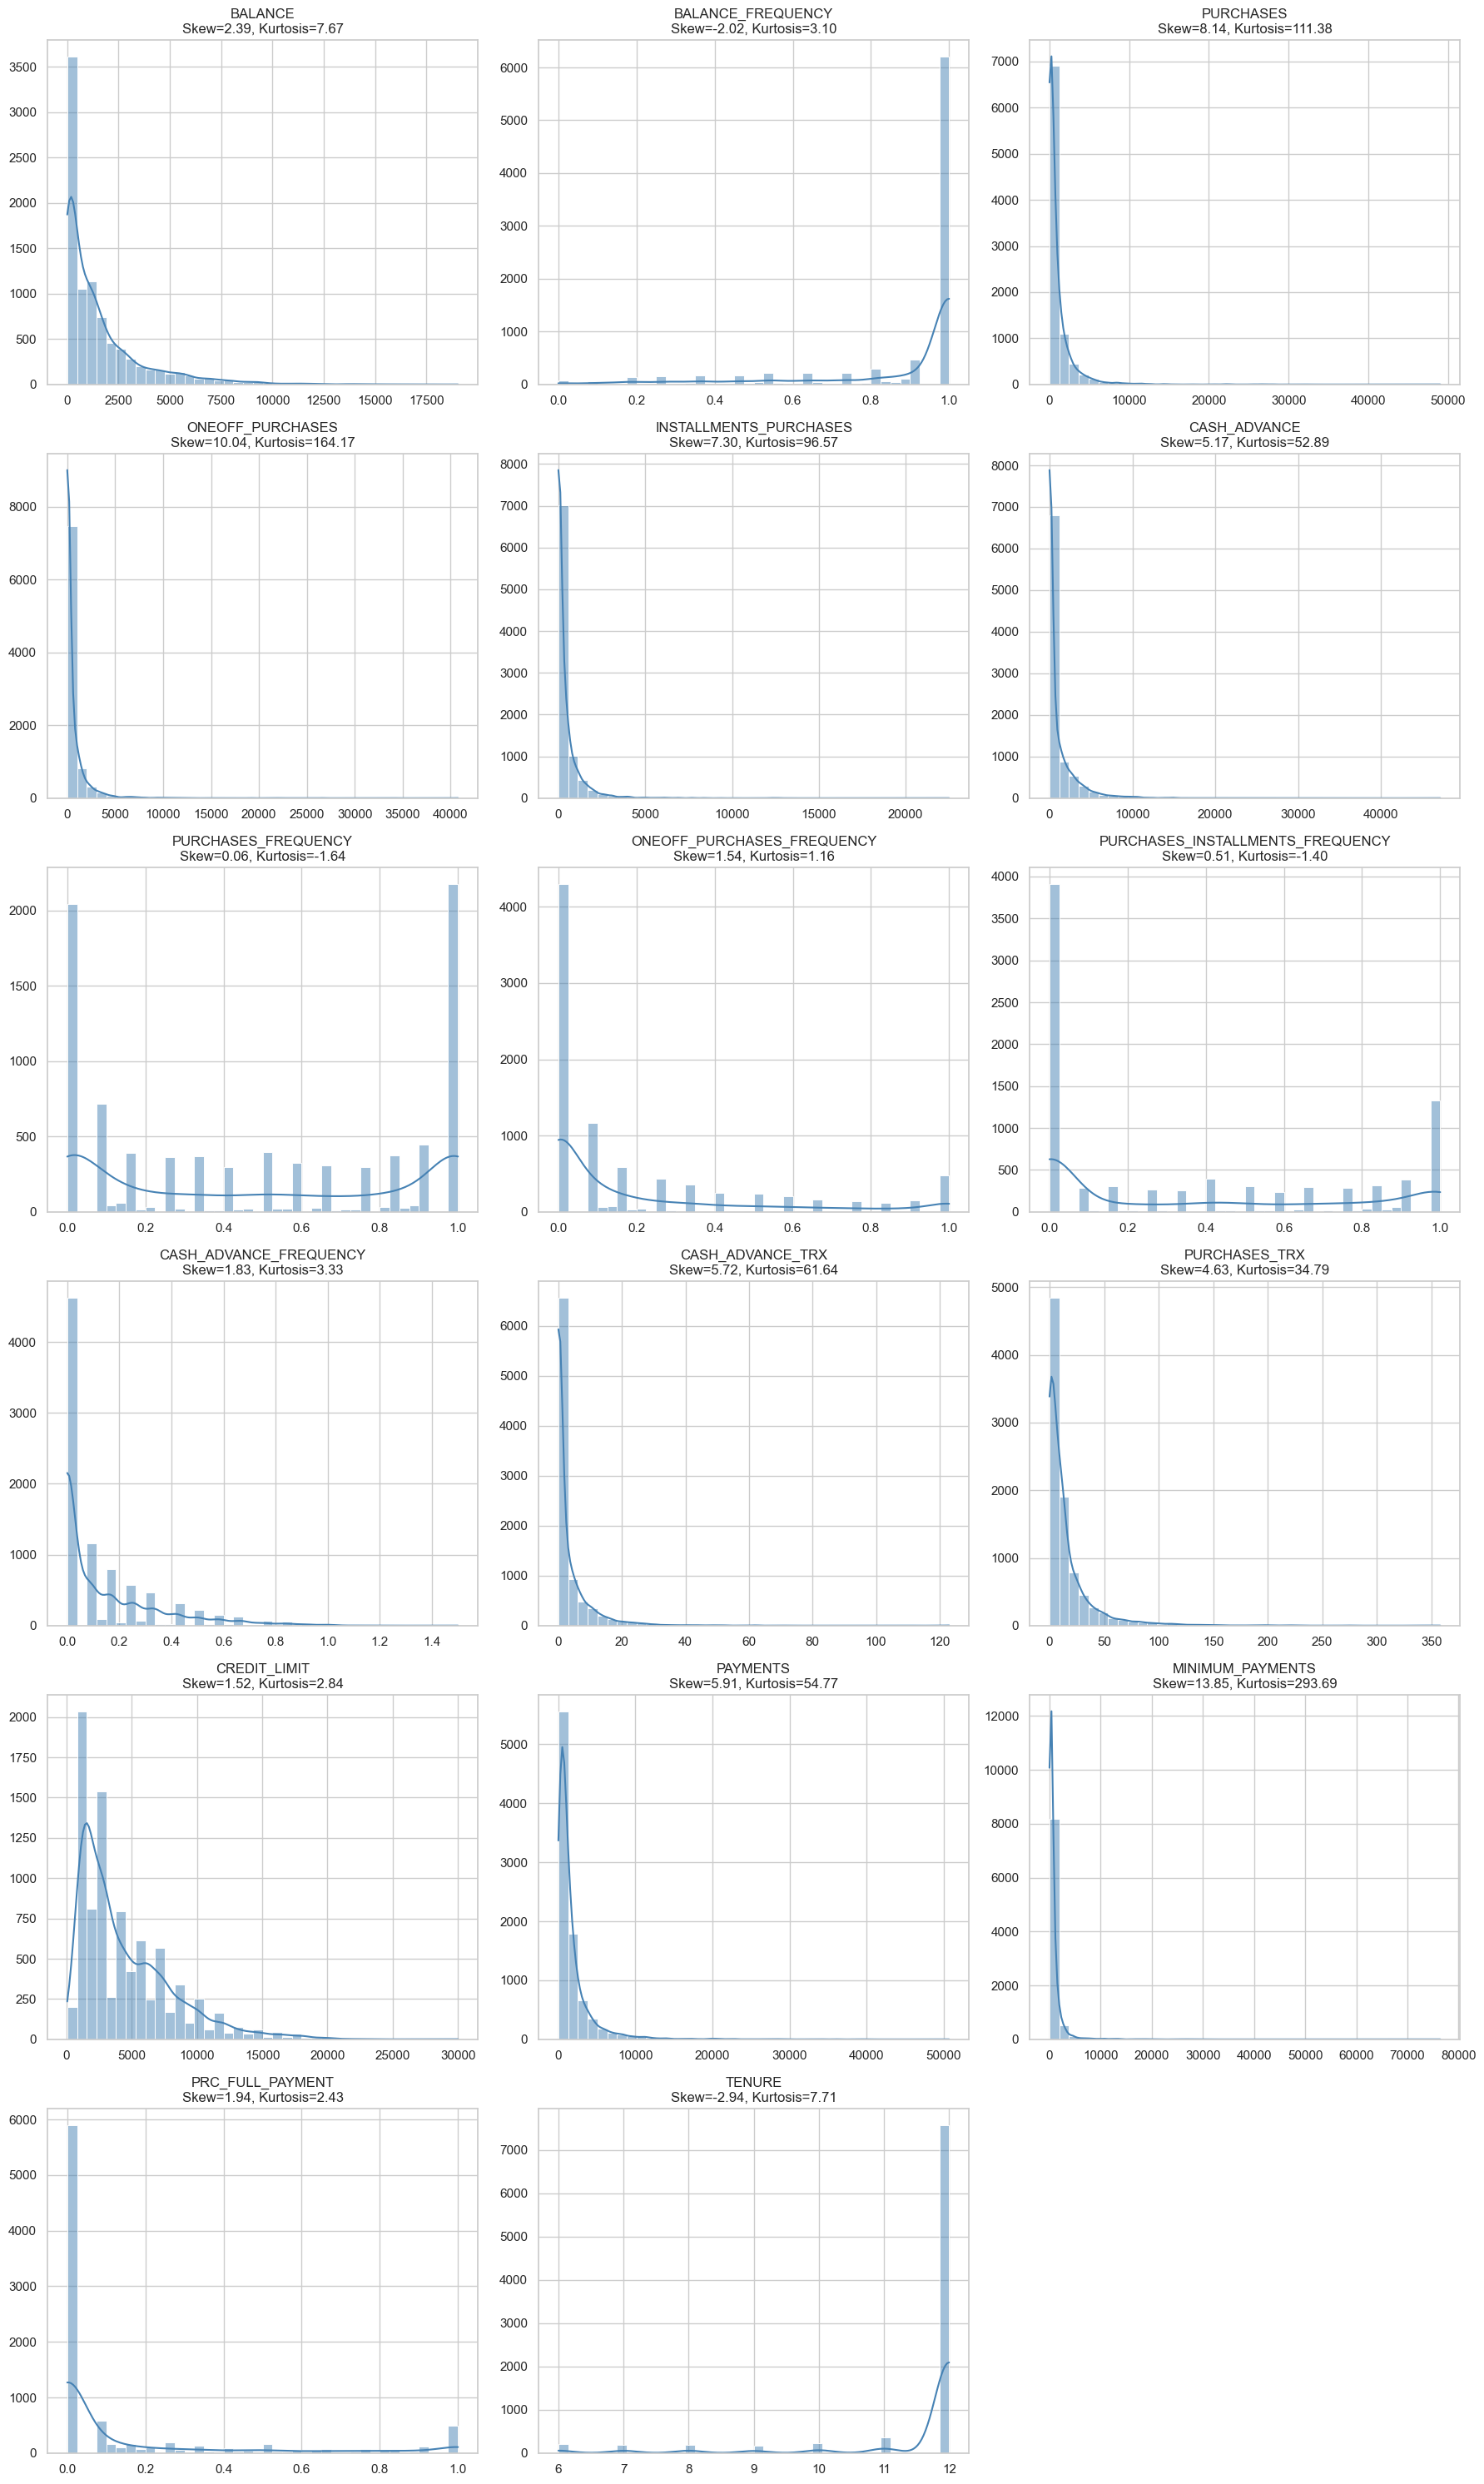

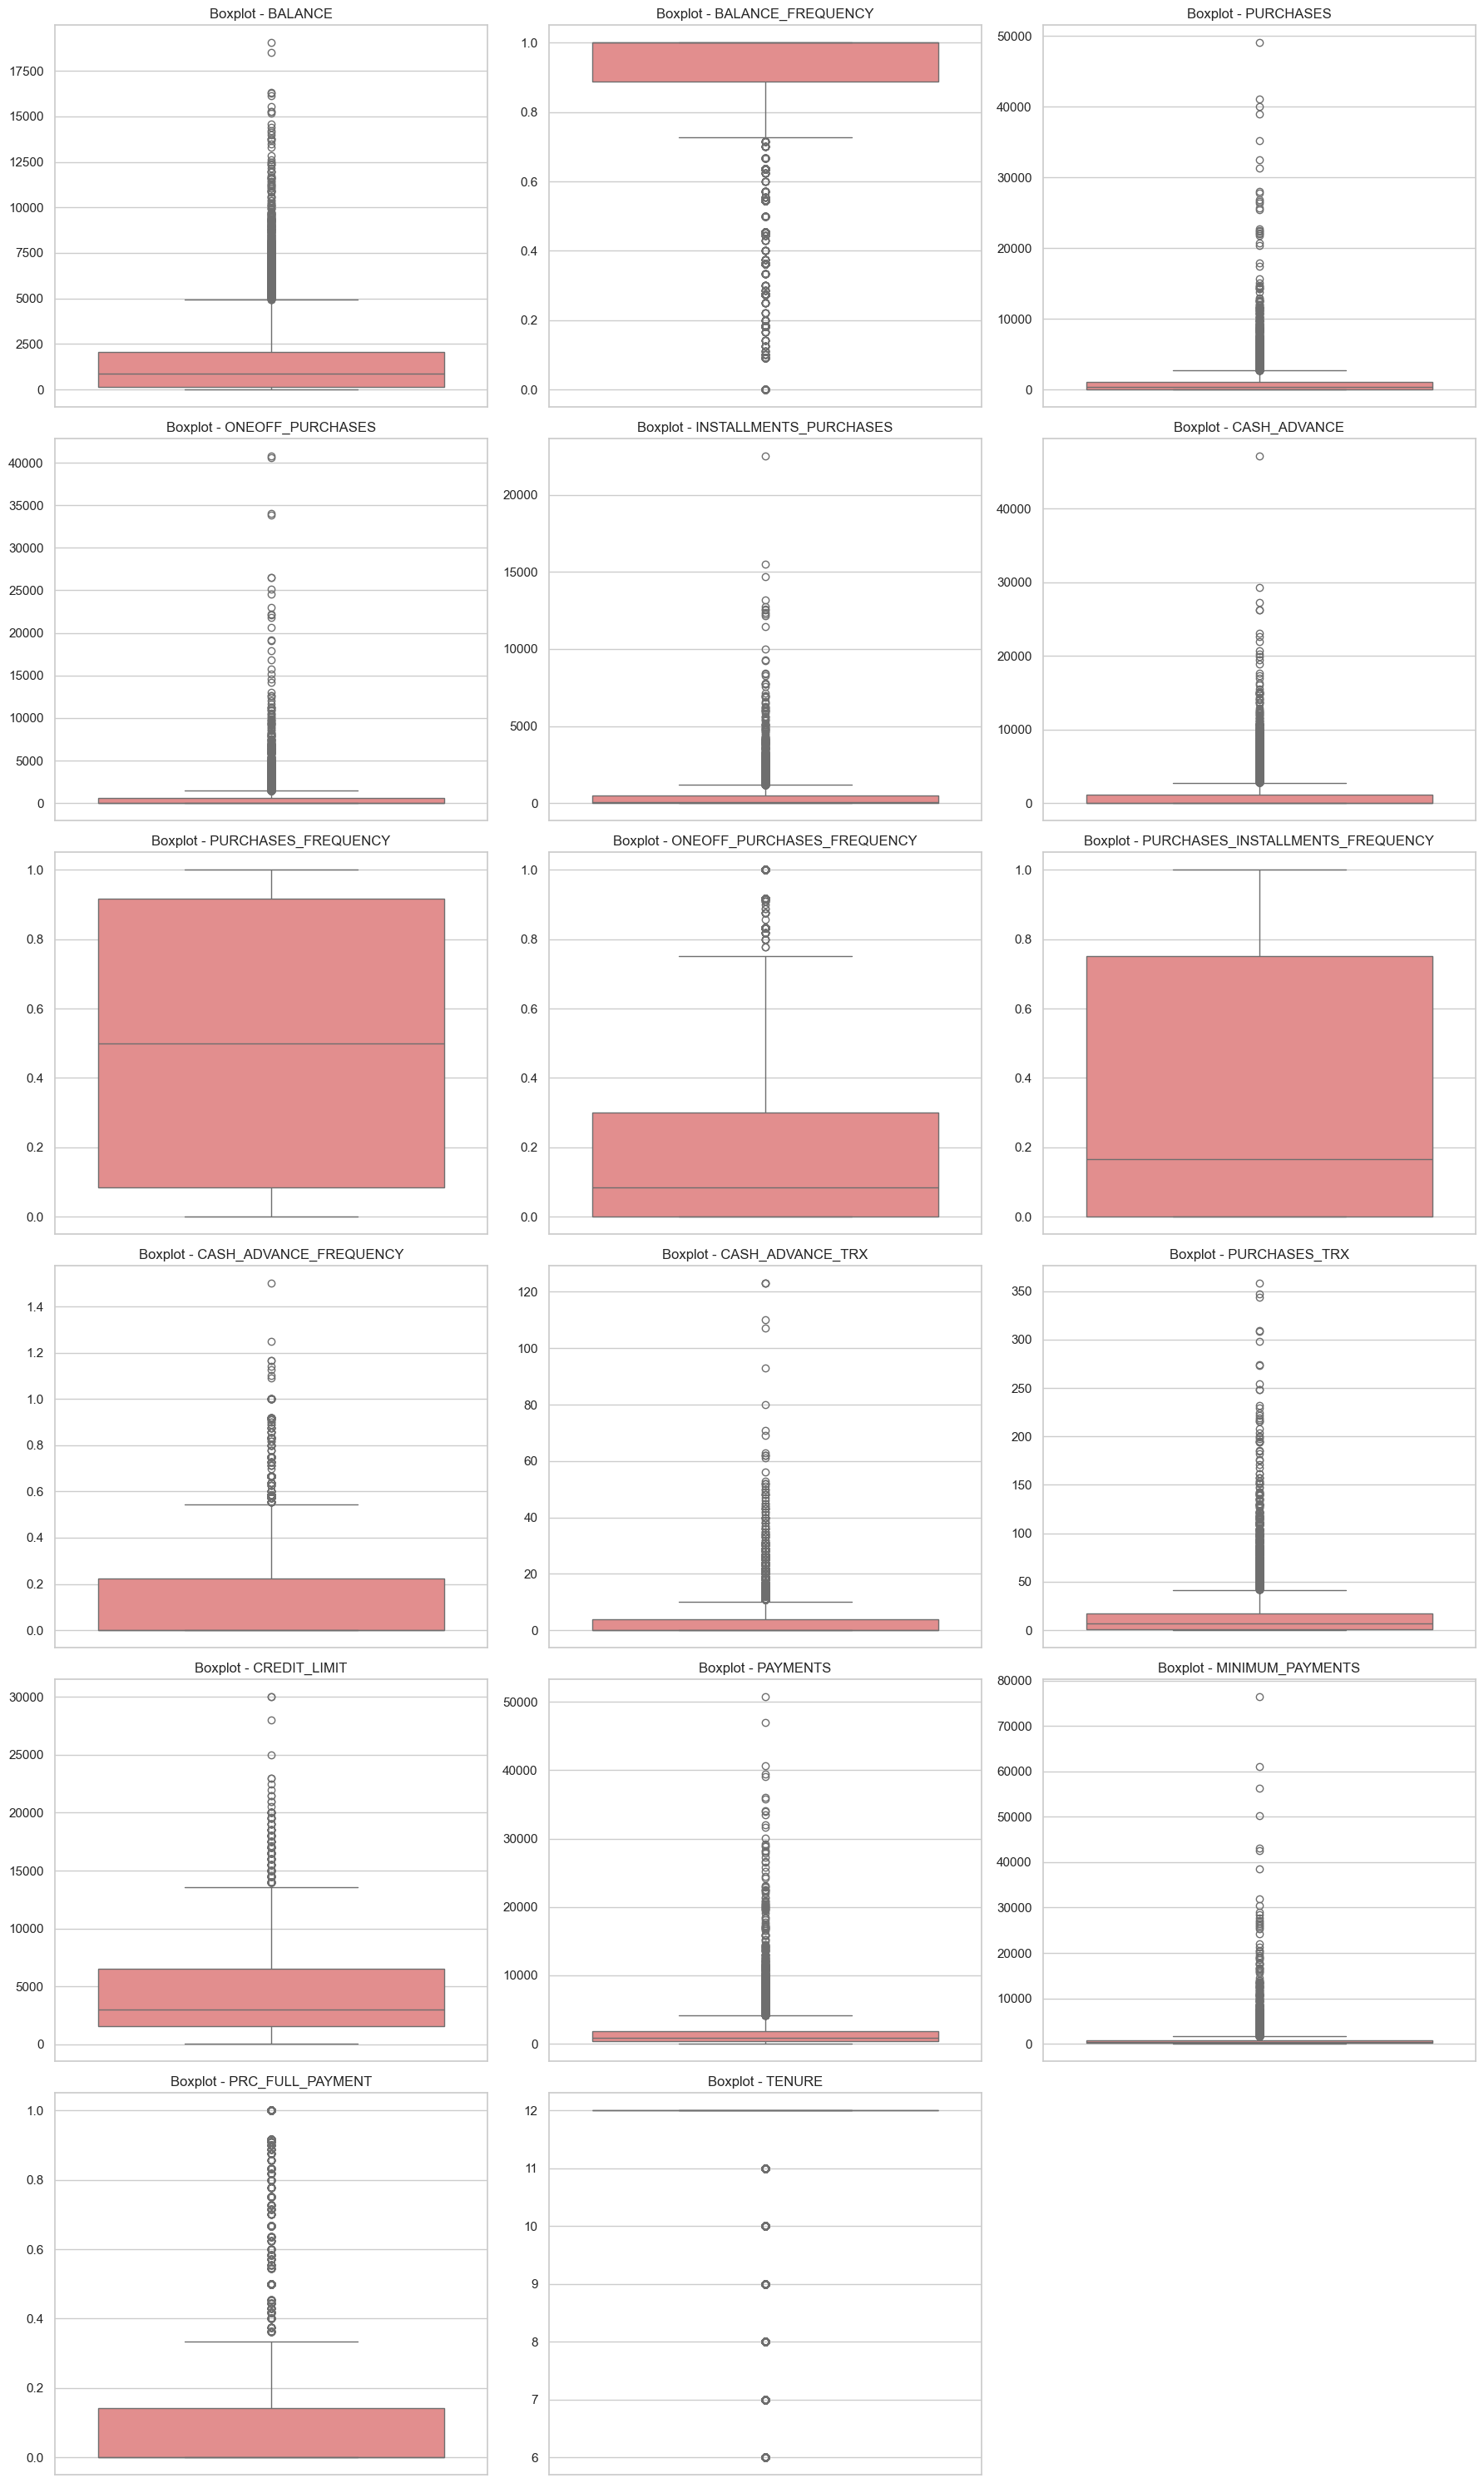

In [16]:
explorar_distribuicoes(X)

In [17]:
# Diagnóstico inicial de distribuição
resultado_dist = diagnostico_distribuicao(X)
display(resultado_dist)

,Variável,Assimetria (Skewness),Curtose,Sugestão de Transformação
14,MINIMUM_PAYMENTS,13.85,293.53,Log (assimetria positiva)
3,ONEOFF_PURCHASES,10.04,164.08,Log (assimetria positiva)
2,PURCHASES,8.14,111.32,Log (assimetria positiva)
4,INSTALLMENTS_PURCHASES,7.30,96.51,Log (assimetria positiva)
13,PAYMENTS,5.91,54.74,Log (assimetria positiva)
10,CASH_ADVANCE_TRX,5.72,61.60,Log (assimetria positiva)
5,CASH_ADVANCE,5.17,52.86,Log (assimetria positiva)
11,PURCHASES_TRX,4.63,34.77,Log (assimetria positiva)
0,BALANCE,2.39,7.67,Log (assimetria positiva)
15,PRC_FULL_PAYMENT,1.94,2.43,Log (assimetria positiva)


In [18]:
# Separar colunas conforme diagnóstico
colunas_log = [
    'MINIMUM_PAYMENTS', 'ONEOFF_PURCHASES', 'PURCHASES', 'INSTALLMENTS_PURCHASES',
    'PAYMENTS', 'CASH_ADVANCE_TRX', 'CASH_ADVANCE', 'PURCHASES_TRX', 'BALANCE',
    'PRC_FULL_PAYMENT', 'CASH_ADVANCE_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'CREDIT_LIMIT'
]

colunas_boxcox = ['BALANCE_FREQUENCY', 'TENURE']

colunas_sem_transformacao = ['PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY']

In [19]:
# Aplicar Log nas variáveis assimétricas positivas
df_log = aplicar_transformacao(X, colunas_log, metodo='log')

# Aplicar Yeo-Johnson nas assimétricas negativas (permite valores zero)
df_final = aplicar_transformacao(df_log, colunas_boxcox, metodo='yeojohnson')

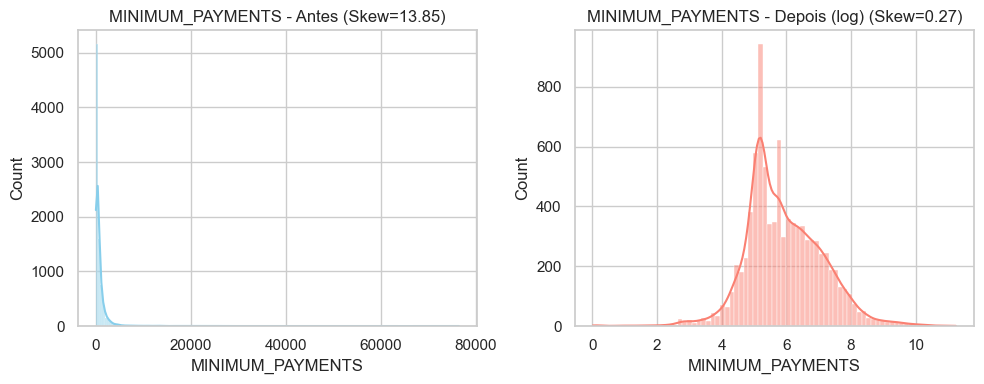

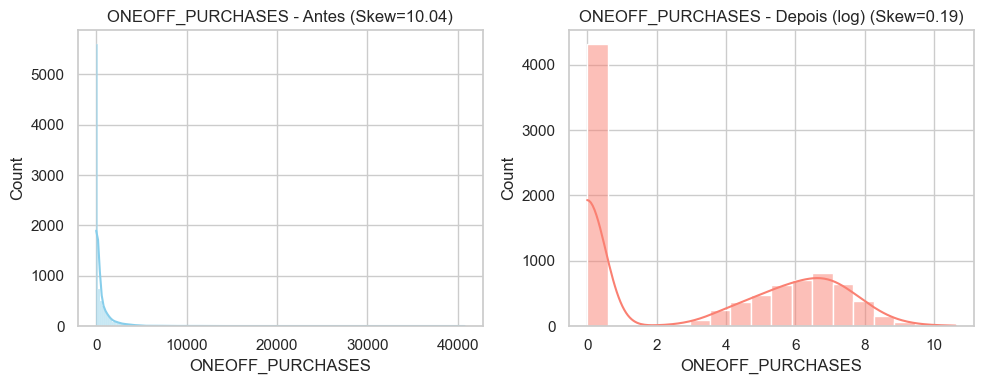

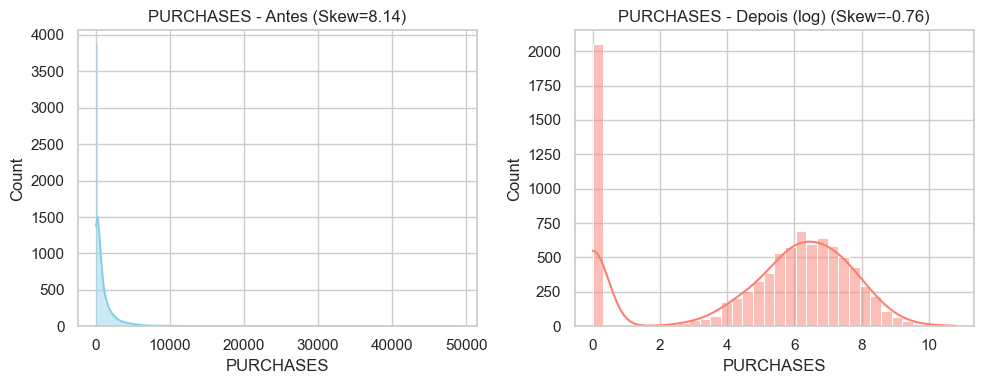

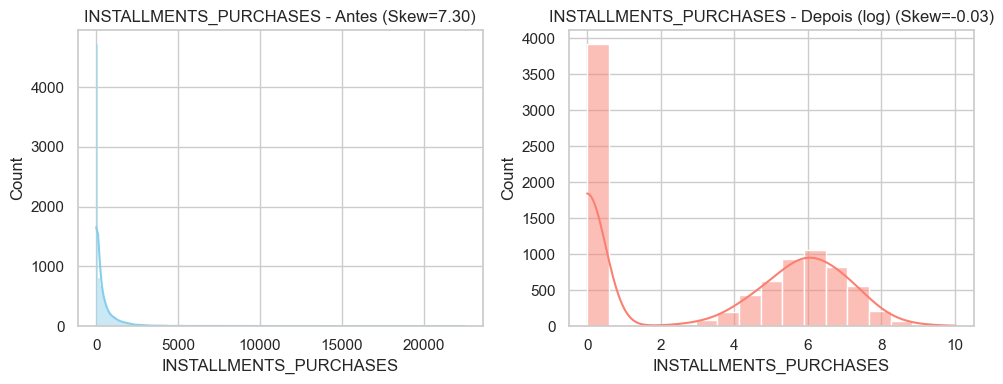

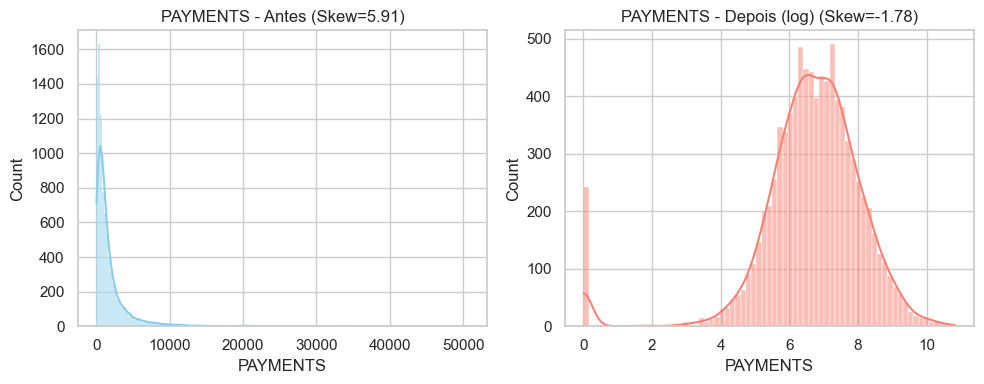

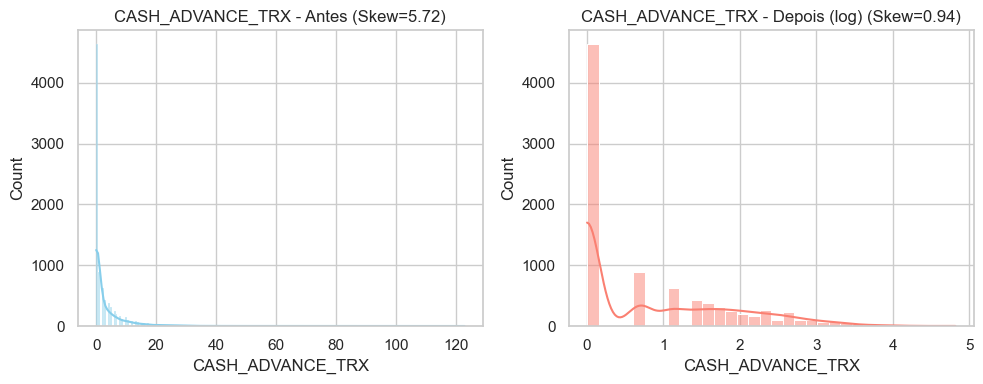

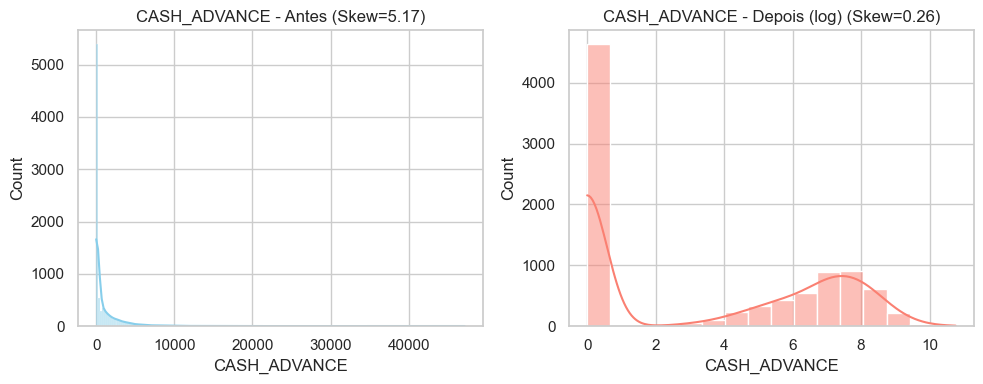

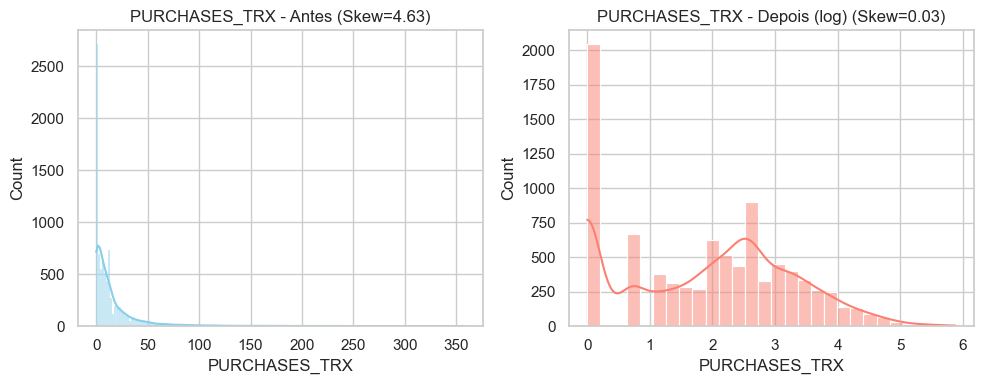

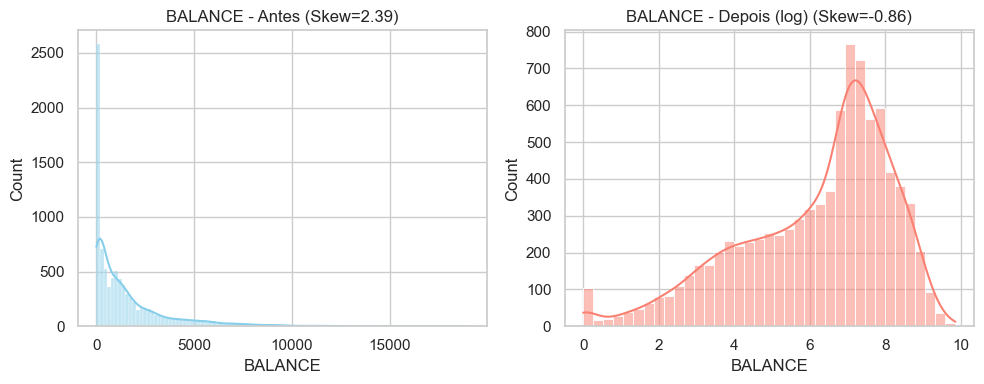

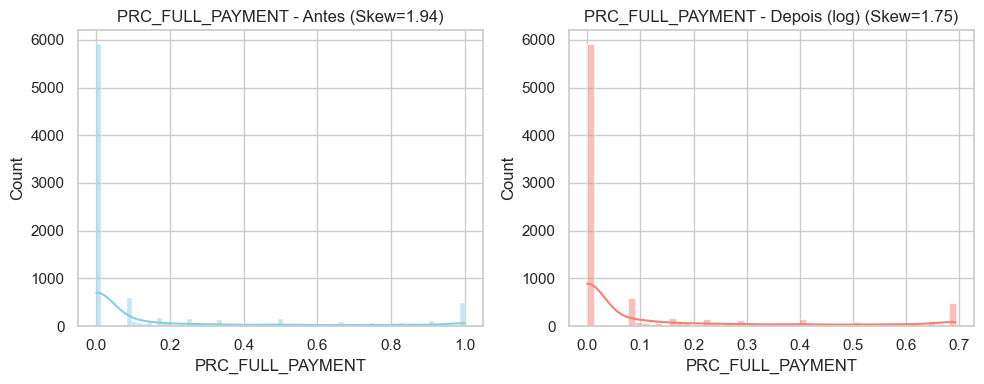

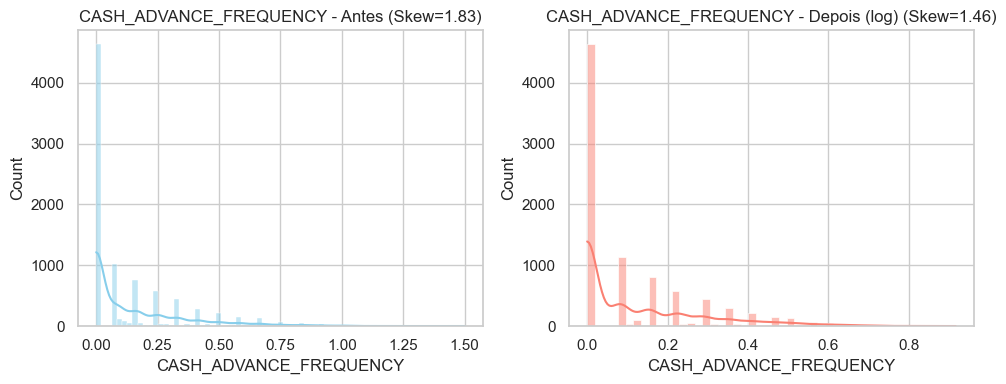

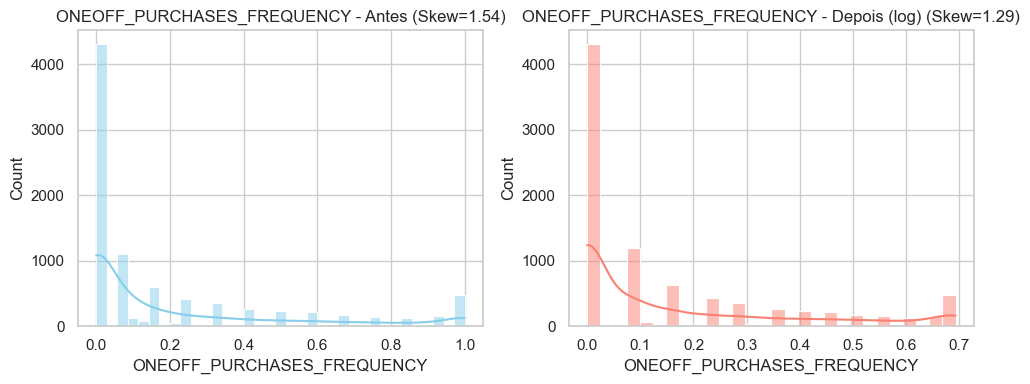

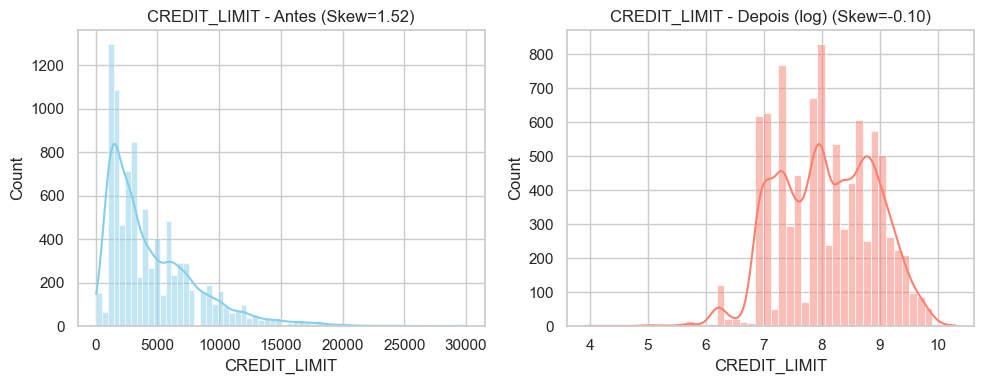

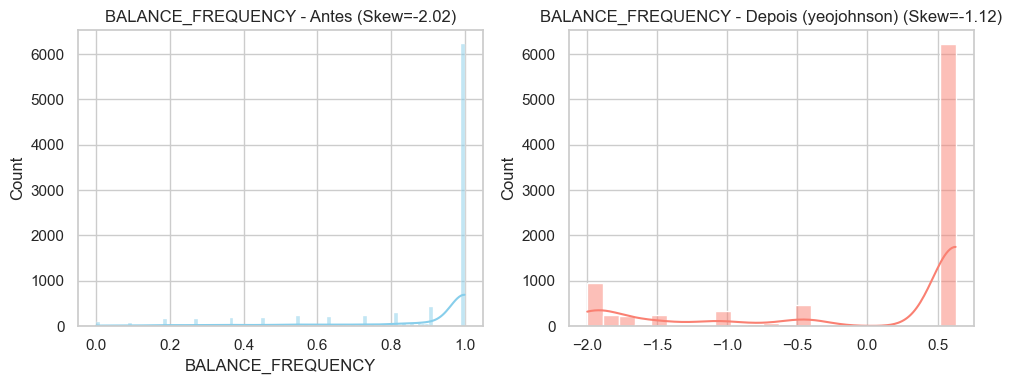

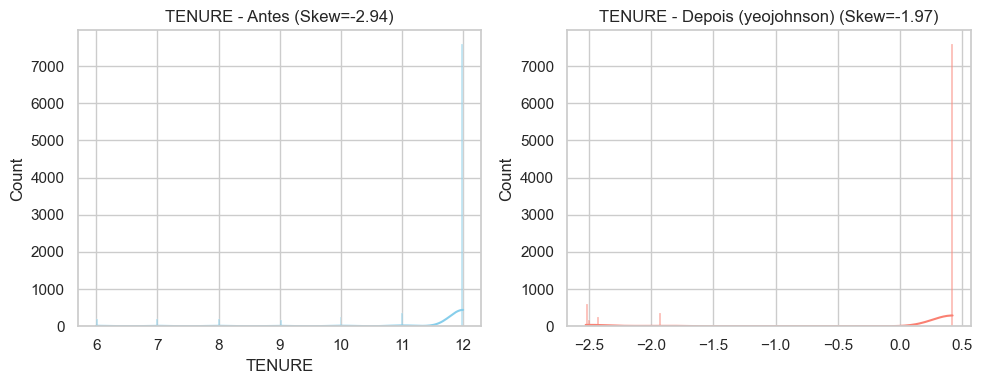

,Variável,Skew antes,Skew depois,Melhorou
0,MINIMUM_PAYMENTS,13.85,0.27,True
1,ONEOFF_PURCHASES,10.04,0.19,True
2,PURCHASES,8.14,-0.76,True
3,INSTALLMENTS_PURCHASES,7.30,-0.03,True
4,PAYMENTS,5.91,-1.78,True
5,CASH_ADVANCE_TRX,5.72,0.94,True
6,CASH_ADVANCE,5.17,0.26,True
7,PURCHASES_TRX,4.63,0.03,True
8,BALANCE,2.39,-0.86,True
9,PRC_FULL_PAYMENT,1.94,1.75,True


,Variável,Skew antes,Skew depois,Melhorou
0,BALANCE_FREQUENCY,-2.02,-1.12,True
1,TENURE,-2.94,-1.97,True


In [22]:
# Comparar variáveis com assimetria positiva (log)
resultado_log = comparar_distribuicoes(X, colunas_log, metodo='log')

# Comparar variáveis com assimetria negativa (Yeo-Johnson)
resultado_yj = comparar_distribuicoes(X, colunas_boxcox, metodo='yeojohnson')

display(resultado_log)
display(resultado_yj)

Identificando colunas numéricas e categóricas

In [23]:
#Identificando colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()


num_cols, cat_cols

(['BALANCE',
  'BALANCE_FREQUENCY',
  'PURCHASES',
  'ONEOFF_PURCHASES',
  'INSTALLMENTS_PURCHASES',
  'CASH_ADVANCE',
  'PURCHASES_FREQUENCY',
  'ONEOFF_PURCHASES_FREQUENCY',
  'PURCHASES_INSTALLMENTS_FREQUENCY',
  'CASH_ADVANCE_FREQUENCY',
  'CASH_ADVANCE_TRX',
  'PURCHASES_TRX',
  'CREDIT_LIMIT',
  'PAYMENTS',
  'MINIMUM_PAYMENTS',
  'PRC_FULL_PAYMENT',
  'TENURE'],
 [])

In [24]:
# Identificação e análise de Outliers
outliers_report = []
for col in num_cols:
    report = detectar_outliers_iqr(df_cluster, col)
    outliers_report.append(report)

outliers_df = pd.DataFrame(outliers_report).sort_values(by='perc_outliers', ascending=False)
display(outliers_df)   # mostra coluna, limites, qtd e % de outliers

,coluna,lim_inf,lim_sup,qtd_outliers,perc_outliers
1,BALANCE_FREQUENCY,0.72,1.17,1493,16.68
15,PRC_FULL_PAYMENT,-0.21,0.36,1474,16.47
16,TENURE,12.00,12.00,1366,15.26
5,CASH_ADVANCE,-1670.73,2784.55,1030,11.51
3,ONEOFF_PURCHASES,-866.11,1443.51,1013,11.32
4,INSTALLMENTS_PURCHASES,-702.96,1171.59,867,9.69
14,MINIMUM_PAYMENTS,-815.42,1810.03,841,9.40
13,PAYMENTS,-1893.51,4177.92,808,9.03
2,PURCHASES,-1566.11,2715.87,808,9.03
10,CASH_ADVANCE_TRX,-6.00,10.00,804,8.98


Conclusão Análise de Outliers  
Os outliers provavelmente representam clientes com comportamento real de uso, não erros.  
**Decisão:** Manter os outliers nesse momento e comparar com o resultado dos clusters.

# Pipeline de transformação

In [25]:
#Padronização Zscore: StandardScaler
#OneHotEncoder: Transformação de variáveis dummy

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
], remainder='drop')  # mantém só o que foi definido

In [26]:
# Transformar os dados com o preprocessador
X_processed = preprocess.fit_transform(X)

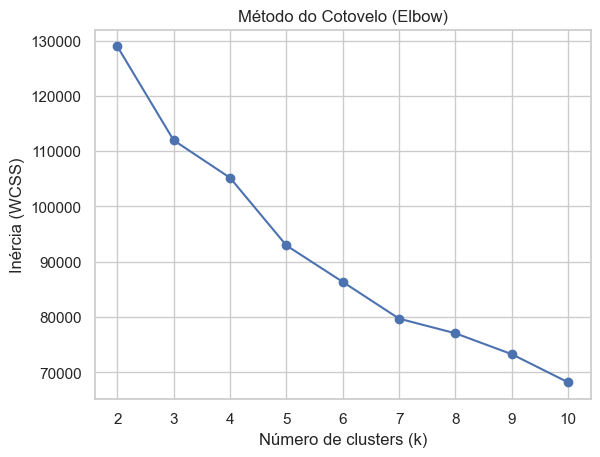

In [27]:
# Testar diferentes valores de k
wcss = []  # within-cluster sum of squares (inércia)

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

# Plot do Elbow
plt.figure()
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Método do Cotovelo (Elbow)')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.show()

k=2, Silhouette Score=0.2796
k=3, Silhouette Score=0.2510
k=4, Silhouette Score=0.2244
k=5, Silhouette Score=0.2099
k=6, Silhouette Score=0.2030
k=7, Silhouette Score=0.2083
k=8, Silhouette Score=0.2049
k=9, Silhouette Score=0.2019
k=10, Silhouette Score=0.2119


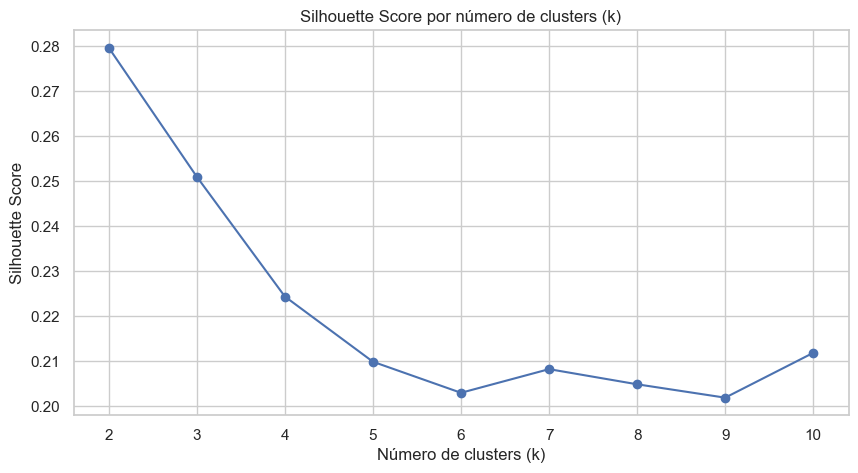

In [28]:
# Silhouette Score
# Lista para armazenar scores
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    sil_scores.append(score)
    print(f'k={k}, Silhouette Score={score:.4f}')

# Plot do Silhouette Score
plt.figure(figsize=(10,5))
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Score por número de clusters (k)')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

k=2, Silhouette Score=0.1752
k=3, Silhouette Score=0.1575
k=4, Silhouette Score=0.1555
k=5, Silhouette Score=0.1693
k=6, Silhouette Score=0.1718
k=7, Silhouette Score=0.1543
k=8, Silhouette Score=0.1458
k=9, Silhouette Score=0.1527
k=10, Silhouette Score=0.1576


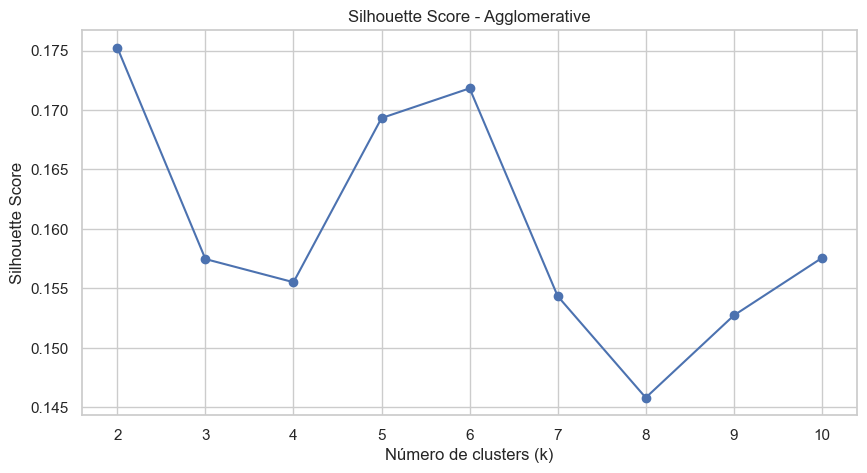

In [43]:
#AgglomerativeClustering
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    sil_scores.append(score)
    print(f'k={k}, Silhouette Score={score:.4f}')

plt.figure(figsize=(10,5))
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Score - Agglomerative')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

eps=0.3, Silhouette Score=-0.4225
eps=0.5, Silhouette Score=-0.4659
eps=0.7, Silhouette Score=-0.4388
eps=1.0, Silhouette Score=-0.2487


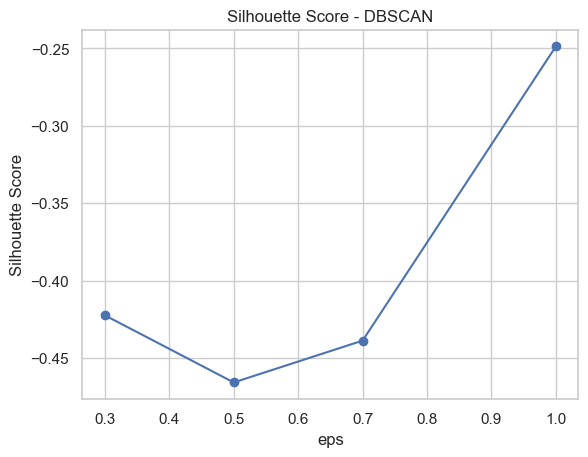

In [44]:
# DBSCAN
eps_values = [0.3, 0.5, 0.7, 1.0]
sil_scores = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_processed)
    # Filtrar se gerou mais de 1 cluster (senão o silhouette falha)
    if len(set(labels)) > 1:
        score = silhouette_score(X_processed, labels)
        sil_scores.append(score)
        print(f'eps={eps}, Silhouette Score={score:.4f}')
    else:
        print(f'eps={eps}: apenas 1 cluster detectado (ignorado)')

plt.plot(eps_values, sil_scores, marker='o')
plt.title('Silhouette Score - DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.show()

Resultado:

K-Means: K=2 e Silhouette 0.2796  
Agglomerative: K=2 e Silhouette 0.1752  
DBSCAN: Negativo. seu resultado (Silhouette negativo) indica que não há densidades naturalmente separáveis.  

Conclusão: O KMeans foi escolhido por apresentar melhor separação com silhouette = 0.2796.

In [ ]:
# Treinamento do modelo final de K-Means e atribuição dos clusters

k_final = 2

kmeans_final = KMeans(n_clusters=k_final, random_state=42)
clusters = kmeans_final.fit_predict(X_processed)

X['cluster'] = clusters


In [31]:
# médias por cluster
means = X.groupby('cluster')[X.select_dtypes(include='number').columns].mean()

# contagem por cluster
sizes = X['cluster'].value_counts()

X['cluster'].value_counts()

cluster
1    7091
0    1858
Name: count, dtype: int64

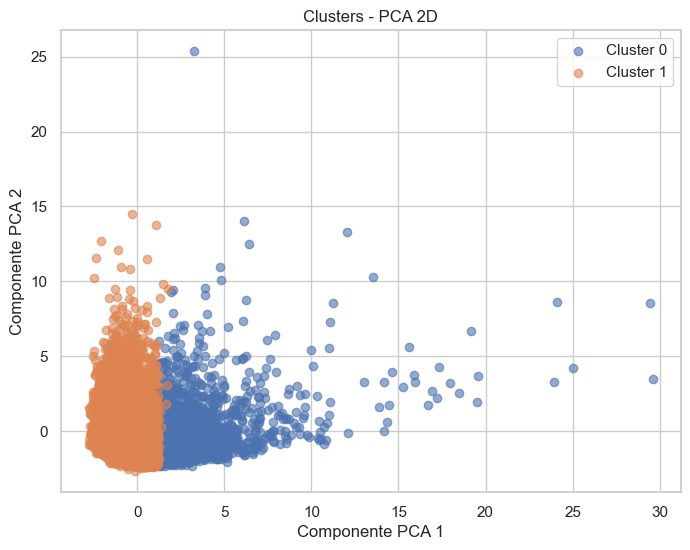

In [32]:
# PCA 2D
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_processed)

clusters = X['cluster']

plt.figure(figsize=(8,6))

# Plot de cada cluster separadamente para legenda
for c in np.unique(clusters):
    ix = clusters == c
    plt.scatter(
        X_pca2[ix, 0],
        X_pca2[ix, 1],
        label=f'Cluster {c}',
        alpha=0.6
    )

plt.title('Clusters - PCA 2D')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.legend()
plt.show()

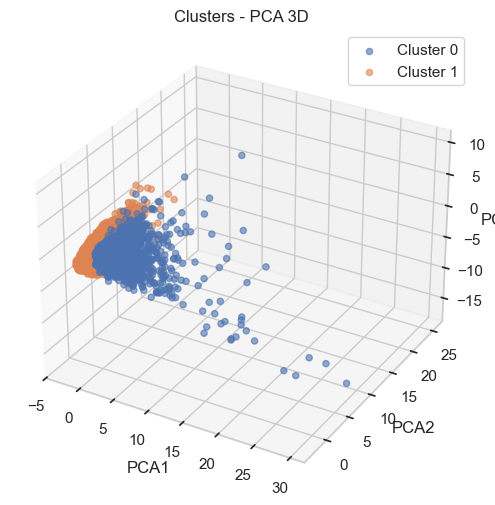

In [33]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_processed)

clusters = X['cluster']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for c in np.unique(clusters):
    ix = clusters == c
    ax.scatter(
        X_pca3[ix, 0],
        X_pca3[ix, 1],
        X_pca3[ix, 2],
        label=f'Cluster {c}',
        alpha=0.6
    )

ax.set_title('Clusters - PCA 3D')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.legend()
plt.show()

In [ ]:
# Estatística F para cada variável

resultado_f = f_test_clusters(X, 'cluster')
resultado_f

# ANOVA(F-test) verifica se as médias de cada variável são diferentes entre os clusters.
# p-value verifica se essa diferença é estatisticamente confiável
# p-value < 0.05: Diferenças significativas entre os clusters
# p-value ≥ 0.05: Diferenças não significativas
# Importancia: Percentual relativo da força dessa variável, calculado como F-stat / soma(F-stat)

,Variável,F-stat,p-value,Importância
7,ONEOFF_PURCHASES_FREQUENCY,6978.42,0.00,0.21
11,PURCHASES_TRX,6468.34,0.00,0.19
6,PURCHASES_FREQUENCY,4323.78,0.00,0.13
2,PURCHASES,4228.04,0.00,0.13
4,INSTALLMENTS_PURCHASES,2953.89,0.00,0.09
3,ONEOFF_PURCHASES,2371.93,0.00,0.07
8,PURCHASES_INSTALLMENTS_FREQUENCY,2261.99,0.00,0.07
12,CREDIT_LIMIT,1491.50,0.00,0.04
13,PAYMENTS,1091.36,0.00,0.03
15,PRC_FULL_PAYMENT,501.41,0.00,0.01


Conclusão Técnica – Análise de Importância das Variáveis (ANOVA)

Os resultados do teste ANOVA indicam que todas as variáveis apresentam significância estatística (p-value < 0.05), confirmando que há diferenças relevantes entre os clusters gerados. No entanto, a magnitude da estatística F evidencia que algumas variáveis possuem maior poder discriminatório na segmentação dos clientes.

As variáveis ONEOFF_PURCHASES_FREQUENCY (F=6978.42, importância=0.21) e PURCHASES_TRX (F=6468.34, importância=0.19) são as que mais contribuem para a diferenciação entre os grupos, seguidas por PURCHASES_FREQUENCY (0.13) e PURCHASES (0.13), reforçando que o padrão de compras e a frequência de transações são determinantes no comportamento dos clientes.

Em contrapartida, variáveis como CASH_ADVANCE, MINIMUM_PAYMENTS e CASH_ADVANCE_TRX apresentam baixa relevância, sugerindo impacto limitado na separação dos segmentos.

Em resumo, os clusters são fortemente explicados por hábitos de compra e frequência de uso do cartão, enquanto operações de adiantamento e pagamentos mínimos têm influência secundária no modelo de segmentação.

In [35]:
# Selecionar apenas colunas numéricas + a coluna cluster
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Garantir que cluster está incluído
if 'cluster' not in num_cols:
    num_cols.append('cluster')

# Criar tabela só com numéricas
df_numeric = X[num_cols]

# Média por cluster
cluster_profile = df_numeric.groupby('cluster').mean().round(2)

cluster_profile

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,2148.24,0.98,3367.87,2076.92,1291.28,762.26,0.94,0.59,0.71,0.08,2.23,46.17,7181.39,3598.14,1195.80,0.29,11.89
1,1411.73,0.85,383.75,203.55,180.49,1035.74,0.37,0.10,0.27,0.15,3.51,6.47,3790.41,1244.72,753.08,0.12,11.42


**Resultado**: 

A aplicação do K-Means resultou em dois grupos distintos de clientes:

**O Cluster 0 (Clientes de Alto Desempenho)**: representa usuários de alto valor, com maior limite de crédito, alta frequência de uso e maior índice de pagamento integral da fatura, indicando clientes mais rentáveis e com bom comportamento financeiro.

    Estratégia Recomendada: Programas de fidelidade, upgrades, ofertas premium

**O Cluster 1 (Clientes de Alto Risco e Baixo Uso Transacional)**: reúne clientes de baixo uso do cartão, com baixo volume de compras e maior utilização de cash advance, sugerindo perfil de crédito emergencial e menor engajamento com o cartão como meio de pagamento.

    Estratégia Recomendada: Estímulo ao consumo (cashback, parcelamento), educação financeira